In [1]:
%matplotlib inline
import pylab

In [2]:
import csv
def load_csv(filename, key):
    rows = {}
    with open(filename, 'rt') as fp:
        r = csv.DictReader(fp)
        for row in r:
            k = row[key]
            rows[k] = row
    return rows

## load mapping summary CSVs and gather CSV

In [3]:
sample_id = 'p8808mo9'
all_map = load_csv(f'outputs/minimap/depth/{sample_id}.summary.csv', 'genome_id')
left_map = load_csv(f'outputs/leftover/depth/{sample_id}.summary.csv', 'genome_id')
gather_csv_raw = load_csv(f'outputs/{sample_id}.gather.csv', 'name')

def fix_name(x):
    return "_".join(x.split('_')[:2]).split('.')[0]

gather_csv = {}
for k in gather_csv_raw:
    genome_id = fix_name(k)
    gather_csv[genome_id] = gather_csv_raw[k]

In [4]:
print(set(all_map.keys()) - set(left_map.keys()))
print(set(all_map.keys()) - set(left_map.keys()))
print(set(all_map.keys()) - set(gather_csv.keys()))
for k in set(gather_csv.keys()) - set(all_map.keys()):
    del gather_csv[k]


set()
set()
set()


In [5]:
import pprint
genome_id = next(iter(gather_csv.keys()))
pprint.pprint(all_map[genome_id])
pprint.pprint(gather_csv[genome_id])

OrderedDict([('', 'GCA_013301655'),
             ('genome bp', '4480179'),
             ('missed', '663996'),
             ('percent missed', '14.820747117470082'),
             ('coverage', '8.677109552988842'),
             ('genome_id', 'GCA_013301655'),
             ('sample_id', 'p8808mo9')])
OrderedDict([('intersect_bp', '2950000'),
             ('f_orig_query', '0.02663488537970512'),
             ('f_match', '0.6609903652251848'),
             ('f_unique_to_query', '0.02663488537970512'),
             ('f_unique_weighted', '0.05055104895104895'),
             ('average_abund', '6.1261016949152545'),
             ('median_abund', '4.0'),
             ('std_abund', '15.356741910032644'),
             ('name', 'GCA_013301655.1_ASM1330165v1_genomic.fna.gz'),
             ('filename', 'all-gather-genomes.sbt.zip'),
             ('md5', '65bf24f31c7e62d1f0186eaceba3b128'),
             ('f_match_orig', '0.6609903652251848'),
             ('unique_intersect_bp', '2950000'),
          

In [6]:
total_bp_mapped = 0
for n, genome_id in enumerate(gather_csv):
    genome_bp = float(left_map[genome_id]['genome bp'])
    percent_missed = float(left_map[genome_id]['percent missed'])
    f_mapped = 1 - (percent_missed/ 100)
    total_bp_mapped += genome_bp * f_mapped
    
print(f'total bp mapped: {total_bp_mapped:e}')

total_hashes = 0
for n, genome_id in enumerate(gather_csv):
    total_hashes += int(gather_csv[genome_id]['unique_intersect_bp']) # XXX @CTB unique_intersect_bp
    
print(f'total hashes identified: {total_hashes:e}')

total bp mapped: 8.135133e+07
total hashes identified: 6.051800e+07


## fig 1: examining leftover reads, in order of gather

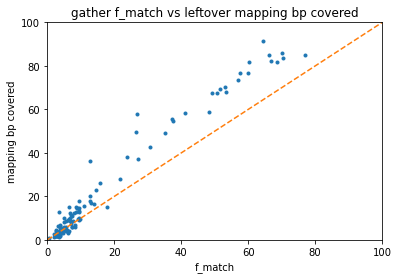

In [7]:
x = []
y1 = []
y2 = []
for n, genome_id in enumerate(gather_csv):
    x.append(n)
    f_match = float(gather_csv[genome_id]['f_match']) * 100
    percent_missed = float(left_map[genome_id]['percent missed'])
    x.append(n)
    y1.append(f_match)
    y2.append(100 - percent_missed)

pylab.plot(y1, y2, '.')
pylab.xlim(0, 100)
pylab.ylim(0, 100)
pylab.xlabel('f_match')
pylab.ylabel('mapping bp covered')
pylab.title('gather f_match vs leftover mapping bp covered')
pylab.plot([0, 100], [0, 100], '--')

## fig 2: fraction of hashes unique to query, in order of gather results

Text(0, 0.5, 'f_unique_to_query, as %')

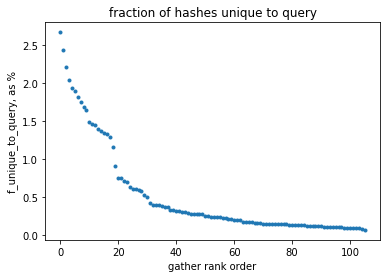

In [8]:
x = []
y1 = []
for n, genome_id in enumerate(gather_csv):
    f_match = float(gather_csv[genome_id]['f_unique_to_query']) * 100
    percent_missed = float(left_map[genome_id]['percent missed'])
    x.append(n)
    y1.append(f_match)

pylab.plot(x, y1, '.')
pylab.title('fraction of hashes unique to query')
pylab.xlabel('gather rank order')
pylab.ylabel('f_unique_to_query, as %')

## fig 3: read counts by sample

In [9]:
if 0:
    read_counts = {}
    with open('leftover.read-counts.txt', 'rt') as fp:
        for line in fp:
            genome_n, counts = line.split()
            genome_n = int(genome_n)
            counts = int(counts)
            read_counts[genome_n] = counts

    x = []
    y = []
    for n, genome_id in enumerate(gather_csv):
        x.append(n)
        y.append(read_counts[int(genome_id)])

    pylab.plot(x, y, '.')

## fig 4: sum mapped bp and sum identified hashes, in order of gather

conclusion: across the gather run, total hashes identified correlate well with total bp mapped

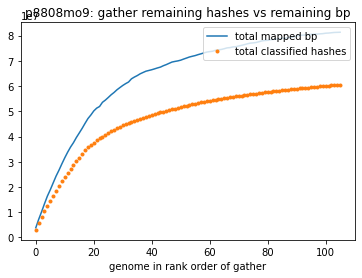

In [10]:
map_x = []
map_bp_mapped = []
map_bp_unmapped = []

sofar = 0
for n, genome_id in enumerate(gather_csv):
    genome_bp = float(left_map[genome_id]['genome bp'])
    percent_missed = float(left_map[genome_id]['percent missed'])
    f_mapped = 1 - (percent_missed / 100)
    bp_mapped = genome_bp * f_mapped
    
    sofar += bp_mapped
    
    map_x.append(n)
    map_bp_mapped.append(bp_mapped)
    map_bp_unmapped.append(sofar)
    
hash_x = []
hash_n_ident = []
hash_n_classified = []
hash_n_ident_all = []

sofar = 0
for n, genome_id in enumerate(gather_csv):
    n_hashes = int(gather_csv[genome_id]['unique_intersect_bp']) # XXX @CTB unique_intersect_bp
    sofar += n_hashes
    hash_x.append(n)
    hash_n_ident.append(n_hashes)
    hash_n_classified.append(sofar)
    
    all_hashes = int(gather_csv[genome_id]['intersect_bp'])
    hash_n_ident_all.append(all_hashes)

pylab.plot(map_x, map_bp_unmapped, '-', label='total mapped bp')
pylab.plot(hash_x, hash_n_classified, '.', label='total classified hashes')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather remaining hashes vs remaining bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')

## fig 5: mapped bp and identified hashes compared by sample, in order of gather

conclusion: for most samples, bp mapped to that genome matches # of hashes classified to that genome

note: hashes classified to this genome is monotonically decreasing, b/c gather is a greedy algorithm.

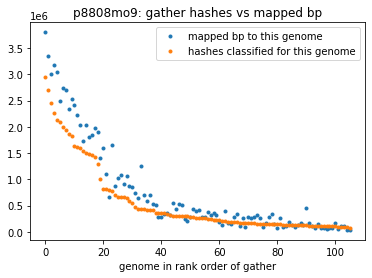

In [11]:
pylab.plot(map_x, map_bp_mapped, '.', label='mapped bp to this genome')
pylab.plot(hash_x, hash_n_ident, '.', label='hashes classified for this genome')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')

## fig 6: difference between sum hash ident and sum bp mapped

Text(0, 0.5, 'difference: total hashcount - mapped bp')

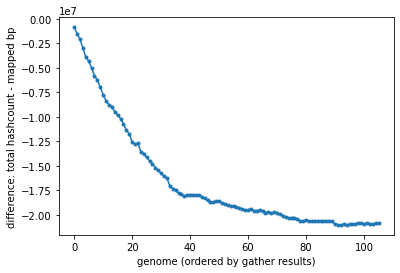

In [12]:
ydiff = [ h - m for (h, m) in zip(hash_n_classified, map_bp_unmapped)]
x = range(len(ydiff))
pylab.plot(x, ydiff, '.-')
pylab.xlabel('genome (ordered by gather results)')
pylab.ylabel('difference: total hashcount - mapped bp')

## fig 7: difference between hashes and bp, per sample

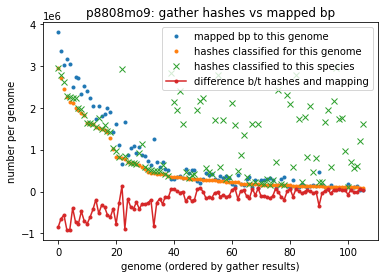

In [14]:
pylab.plot(map_x, map_bp_mapped, '.', label='mapped bp to this genome')
pylab.plot(hash_x, hash_n_ident, '.', label='hashes classified for this genome')
pylab.plot(hash_x, hash_n_ident_all, 'x', label='hashes classified to this species')


ydiff = [ h - m for (h, m) in zip(hash_n_ident, map_bp_mapped)]
x = range(len(ydiff))
pylab.plot(x, ydiff, '.-', label='difference b/t hashes and mapping')
pylab.xlabel('genome (ordered by gather results)')
#pylab.ylabel('difference: hashcount - mapped bp')
pylab.ylabel('number per genome')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')
pylab.savefig(f'/tmp/gather-{sample_id}.svg')